# Functioning Water Pumps

The subsaharan nation of Tanzania has had a long history of issues surround potable drinking water. A significant percentage of the nation's inhabitants lack access to clean water for drinking and basic sanitation. This is well recognized by the global community as the vast majority of funding for Water infrastructure came from outside the country. Furthermore, close to 40% of water pumps are operational throughout the nation. The purpose of this model is to predict which water pumps are non-functioning or in need of repair to better allocate resources towards maintenance. 

In [4]:
%cd .. 
%cd data

/Users/azel/github/Tanzanian_Water_Pumps
/Users/azel/github/Tanzanian_Water_Pumps/data


In [5]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

from scipy.stats import randint

import category_encoders as ce

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split

from xgboost import XGBClassifier

import eli5
from eli5.sklearn import PermutationImportance

import shap

import folium

pd.set_option('display.max_columns', 500)

In [6]:

data         = pd.read_csv('train_features.csv')
feature_info = pd.read_csv('train_labels.csv')
X_val        = pd.read_csv('test_features.csv')
sample_submi = pd.read_csv('sample_submission.csv')


feature_info = feature_info.drop(columns = 'id')
df = pd.concat([data, feature_info], sort = False, axis = 1)

X = data
y = feature_info['status_group']


print(X.shape, '\n')
X.head()

(59400, 40) 



,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


## Data Cleaning


##### Messy Data
As the saying goes "garbage in, garbage out" data cleaning methodology is very important for this dataset. There is a lot of garbage data. Multiple features are duplicates, or similar with varying degrees of detail. For this model, I aimed at keeping unique features that have the most detail. In the cases of high-cardinality data, I also cleaned the entries somewhat as often times they would be mispelled. That dropped cardinality and attempted to pursue the more macro trends in the data. Null values were either imputed by the categorical encoding (mean) or based on location. 

##### Encoding Categorical Data
Finally, I opted for two types of encoding. Ordinal Encoding for my ordinal data (which was fairly limited), and [Leave One Out Encoding](http://contrib.scikit-learn.org/categorical-encoding/leaveoneout.html) for my nominal data. Leave one out encoding is useful for handling nominal categorical features that have a high cardinality. It works by calculating the mean of the target variables for all the records containing the same value for feature in question. The encoding algorithm is slightly different between training and test data set. The training dataset for the record under consideration is left out, hence the name Leave One Out. As a result, the data is less contaminated than features encoded by Target Encoding. Thus, it is less prone to overfitting. 



In [3]:
def null_wrangle(X):
        
    """
    This function identifies null values and catches "bad data" based on unusual 
    distribution and obvious outliers. It then imputes a number of features using 
    generalized latitude and longitude to impute the value based on the associated region.
    Finally, it ordinally encodes the quantity feature. 

    Parameters
    ----------
    X : pandas.DataFrame
        Dataset to be fixed

    Returns
    ----------
    Xn : pandas.DataFrame

    """
    
    Xn = X.copy()
    
    # Focusing on numeric features as they all can be accurately imputed geographically.
    columns = Xn.select_dtypes('number').columns
    
    # Each of these features use 0 to represent a null value. 
    Xn[columns] = Xn[columns].replace(0,np.nan)
    
    # Similar to 0, this number is also essentially null. Longitude uses 0
    Xn['latitude'] = Xn['latitude'].replace(-2.000000e-08 ,np.nan)
    
    # Bin coordinates for generalization. 
    Xn['lon_bin'] = round(Xn['longitude'], 2)
    Xn['lat_bin'] = round(Xn['latitude'], 2)
    
    columns = Xn.select_dtypes('number').columns
    
    # Imputing null values based on geography. 
    for feature in columns:
        replacements = Xn[columns].groupby('region_code')[feature].transform('mean')
        Xn[feature] = Xn[feature].fillna(replacements)
    
    for feature in columns:
        replacements = Xn[columns].groupby(['lon_bin', 'lat_bin'])[feature].transform('mean')
        Xn[feature] = Xn[feature].fillna(replacements)

    for feature in columns:
        replacements = Xn[columns].groupby('district_code')[feature].transform('mean')
        Xn[feature] = Xn[feature].fillna(replacements)
    
    for feature in columns:
        replacements = Xn[columns].groupby('lat_bin')[feature].transform('mean')
        Xn[feature] = Xn[feature].fillna(replacements)
    
    
    # Moving on to Categorical Data
    columns = Xn.select_dtypes(exclude = 'number')
    
    # Cleaning the data so that everything is lower case. This removes a lot of 
    ## unnecessary Cardinality. 
    
    for feature in columns:
        Xn[feature] = Xn[feature].str.lower()
        
    # Ordinally Encode Quantity. It only works here in the workflow. 
    Xn['quantity'] = Xn['quantity'].replace({'enough' : 4 , 'insufficient' : 3 , 
                                             'seasonal' : 2 , 'dry' : 1 , 'unknown' : 0})    
    
    # Cleaning false NaN values and changing them to NaN
    nan_list = ['0','not known','unknown','none','-','##','not kno','unknown installer']
    Xn = Xn.replace(nan_list, np.nan)
    
    return Xn

In [4]:
def note_wrangle (X):
     
    """
    The Data contained a lot of values that were improperly unique. Whomeever 
    recorded the data did not have established guidelines for format and spelling. 
    As a result, the data contained a lot of mispelled words and abbreviations. 
    Given the importance of the information I cleaned some of the most important values. 
    This is by no means a comprehensive list, given how unique the variations were it would 
    be difficult to impute these values computationally. 

    Parameters
    ----------
    X : pandas.DataFrame
        Dataset to be fixed

    Returns
    ----------
    Xn : pandas.DataFrame

    """
    
    Xn = X.copy()
    
    # Explicitly defined lists based on spelling mistakes and inconsistent naming conventions. 
    gov_list = ['central government','tanzania government','cental government',
                'cebtral government','government of tanzania','ministry of water',
                'gov','gove','govern','gover','governme','governmen','go','idara ya maji',
                'DWE']

    Xn = Xn.replace(gov_list, 'government') 
    
    ######
    germ_list = ['germany republi', 'aco/germany','a/co germany']

    Xn = Xn.replace(germ_list, 'germany')
    
    ######
    priv_list = ['private individual','private owned','pr','priva']

    Xn = Xn.replace(priv_list, 'private')

    #######
    fini_list = ['finida german tanzania govt','fini water','finidagermantanzania govt']

    Xn = Xn.replace(fini_list, 'fini')

    # Important and very common spelling mistakes. 
    Xn = Xn.replace('unisef', 'unicef')
    Xn = Xn.replace('danid', 'danida')

    # Automatically generated lists
    comm_list = (Xn.loc[df['installer'].str.contains('com') == True]['installer']
                 .value_counts()
                 .index
                 .tolist())

    Xn = Xn.replace(comm_list, 'community')
    
    ######
    miss_list = (Xn.loc[Xn['installer'].str.contains('missi') == True]['installer']
                 .value_counts()
                 .index
                 .tolist())

    Xn = Xn.replace(miss_list, 'missionary')

    ######
    local_council = (Xn.loc[Xn['installer'].str.contains('cou') == True]['installer']
                     .value_counts()
                     .index
                     .tolist())

    Xn = Xn.replace(local_council, 'local council')
    
    return Xn

In [5]:
def drop_features(X):
    X = X.drop(columns = ['num_private','latitude','longitude','public_meeting',
                          'scheme_name','scheme_management','permit','payment',
                          'payment_type','subvillage','wpt_name','lat_bin','lon_bin',
                          'source_type','quantity_group','management_group','quality_group',
                          'waterpoint_type_group','extraction_type_class','region','district_code',
                          'recorded_by','id','date_recorded'])
        
    return X

In [6]:
def drop_features_viz(X):
    X = X.drop(columns = ['num_private','public_meeting','permit','payment',
                          'scheme_name','scheme_management','date_recorded',
                          'payment_type','subvillage','wpt_name','lat_bin','lon_bin',
                          'source_type','quantity_group','management_group','quality_group',
                          'waterpoint_type_group','extraction_type_class','recorded_by','id',])
    
    return X

In [7]:
def low_occurance_wrangle(X):
    
    """

    This function is for the high cardinality features. A general approach to sweep up any 
    minimally occuring values which were variations and spelling mistakes that I did not 
    address. It replaces all these values with a value value: small_fry. It attempts to make
    and values in the categorical feature more notable by aggregating the noise. 
    

    Parameters
    ----------
    X : pandas.DataFrame
        Dataset to be fixed

    Returns
    ----------
    Xn : pandas.DataFrame
    
    """
    
    Xn = X.copy()
    
    columns = []
    
    # List Comprehension to get a list of the features I'm manipulating. 
    for feature in Xn.select_dtypes(exclude ='number').columns:
        if Xn[feature].nunique() > 20:
            columns.append(feature)
        else:
            pass

    # Quick and dirty one line function to replace those values with small_fry.
    Xn[columns] = Xn[columns].apply(lambda x:
                         x.mask(x.map(x.value_counts())<3, 'small_fry'))
    
    return(Xn)

In [8]:
def dropping_nulls(X):
    return X.dropna()

In [9]:
def loo_encode_val(X, y, X_val):
    
    """
    Leave One Out Encoder encodes a DF of nominal categorical features, based on the
    multiclass target.  LOO encoding is designed to work with
    binary labels; in order to make it work with a target that has three
    values, I encode against a binary version of each and then
    concatenate the results. Refactored function based on Daniel Martin-Alarcon's function.

    Parameters
    ----------
    X : pandas.DataFrame
        Dataset to be fixed

    X_val : pandas.DataFrame
            Validation Data
            Only use if encoding X_val
    
    y : pandas.DataFrame
        Target Dataset

    Returns
    ----------
    X_val : pandas.DataFrame
            Fixed vector

    """
    nominal_features = X.select_dtypes(exclude = 'number').columns
    
    # Declaring my target binaries. 
    y_works = [1.0 if x == 'functional' else 0.0 for x in y]
    y_broken = [1.0 if x == 'non functional' else 0.0 for x in y]
    y_repair = [1.0 if x == 'functional needs repair' else 0.0 for x in y]

    y_vectors = [y_works, y_broken, y_repair]
    X_loo_all = []

    #Encoding to each target
    for i in [1,2,3]:
        
        # Define my encoder. You can set impute strategy here as well. 
        LOO = ce.LeaveOneOutEncoder()
        
        # Fit it to the training data
        LOO.fit(X=X[nominal_features], y=y_vectors[i-1])

        # Transform the categorical features in X
        X_loo = LOO.transform(X_val[nominal_features])
        
        # Naming my the new features
        X_loo = X_loo.rename(columns=(lambda x: x + '_loo' + str(i)))
        X_loo_all.append(X_loo)

    new_features = pd.concat(X_loo_all, sort=False, axis=1)
    
    X_val = X_val.drop(columns=nominal_features)
    X_val = pd.concat([X_val,new_features], sort=False, axis=1)
    
    return X_val

In [10]:
def wrangle(X):
    
    """

    This is a quick function to pipeline data for my model. I am using this instead of 
    the sklearn pipeline for easy refactoring and customizability. I wanted to keep my notebook 
    as true to the iterative process as possibile. Otherwise then I would likely use 
    make_pipeline to keep everything compact. 
    

    Parameters
    ----------
    X : pandas.DataFrame
        Dataset to be fixed

    Returns
    ----------
    Xn : pandas.DataFrame
    
    """
    
    Xn = X.copy()
    Xn = null_wrangle(Xn)
    Xn = note_wrangle(Xn)
    Xn = drop_features(Xn)
    Xn = low_occurance_wrangle(Xn)
    
    return Xn

In [11]:
def wrangle_viz(X):
    
    """

    Similar to the function above, I am using a wrangling function to piece together my data
    for visualization purposes. I do not encode the data and opt to drop noisy data. This 
    will not feed a model. 
    

    Parameters
    ----------
    X : pandas.DataFrame
        Dataset to be fixed

    Returns
    ----------
    Xn : pandas.DataFrame
    
    """
    
    Xn = X.copy()
    Xn = null_wrangle(Xn)
    Xn = note_wrangle(Xn)
    Xn = drop_features_viz(Xn)
    Xn = dropping_nulls(Xn)
    
    
    return Xn

In [12]:
X     = wrangle(X)
X_val = wrangle(X_val)

X_val = loo_encode_val(X , y, X_val)
X     = loo_encode_val(X , y, X)

df    = wrangle_viz(df)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1, 
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((53460, 42), (5940, 42), (53460,), (5940,))

## Checking on my Data

In [14]:
print("Null Values? ")
X_val.isnull().sum().sum() , X_val.isnull().sum().sum()

Null Values? 


(0, 0)

In [15]:
X.head()

,amount_tsh,gps_height,region_code,population,construction_year,quantity,funder_loo1,installer_loo1,basin_loo1,lga_loo1,ward_loo1,extraction_type_loo1,extraction_type_group_loo1,management_loo1,water_quality_loo1,source_loo1,source_class_loo1,waterpoint_type_loo1,funder_loo2,installer_loo2,basin_loo2,lga_loo2,ward_loo2,extraction_type_loo2,extraction_type_group_loo2,management_loo2,water_quality_loo2,source_loo2,source_class_loo2,waterpoint_type_loo2,funder_loo3,installer_loo3,basin_loo3,lga_loo3,ward_loo3,extraction_type_loo3,extraction_type_group_loo3,management_loo3,water_quality_loo3,source_loo3,source_class_loo3,waterpoint_type_loo3
0,6000.000000,1390.0,11,109.000,1999.000,4,0.821818,0.606383,0.653687,0.774823,0.611111,0.599253,0.599253,0.504234,0.565941,0.622290,0.542320,0.621485,0.145455,0.319149,0.297148,0.205674,0.361111,0.299888,0.299888,0.426864,0.357236,0.302744,0.397825,0.299278,0.032727,0.074468,0.049164,0.019504,0.027778,0.100859,0.100859,0.068902,0.076823,0.074966,0.059855,0.079237
1,584.158038,1399.0,20,280.000,2010.000,3,0.811321,0.846154,0.497658,0.592179,0.605634,0.599253,0.599253,0.599540,0.565941,0.603922,0.545168,0.621485,0.188679,0.153846,0.405835,0.370112,0.352113,0.299888,0.299888,0.301458,0.357236,0.259259,0.336960,0.299278,0.000000,0.000000,0.096507,0.037709,0.042254,0.100859,0.100859,0.099002,0.076823,0.136819,0.117872,0.079237
2,25.000000,686.0,21,250.000,2009.000,4,1.000000,0.625179,0.600895,0.581169,0.900000,0.599253,0.599253,0.504234,0.565941,0.385671,0.545168,0.366213,0.000000,0.247496,0.345749,0.402597,0.100000,0.299888,0.299888,0.426864,0.357236,0.577744,0.336960,0.527609,0.000000,0.127325,0.053356,0.016234,0.000000,0.100859,0.100859,0.068902,0.076823,0.036585,0.117872,0.106177
3,173.577181,263.0,90,58.000,1986.000,1,0.567644,0.620482,0.371689,0.265823,0.187500,0.551217,0.538760,0.504234,0.565941,0.489571,0.542320,0.366213,0.338694,0.343373,0.555753,0.734177,0.812500,0.401134,0.420295,0.426864,0.357236,0.466095,0.397825,0.527609,0.093661,0.036145,0.072557,0.000000,0.000000,0.047649,0.040945,0.068902,0.076823,0.044334,0.059855,0.106177
4,32.857143,23.0,18,200.875,2003.875,2,0.617490,0.555556,0.497658,0.530480,0.846154,0.599253,0.599253,0.598341,0.565941,0.603922,0.545168,0.621485,0.333080,0.400000,0.405835,0.411154,0.153846,0.299888,0.299888,0.336493,0.357236,0.259259,0.336960,0.299278,0.049430,0.044444,0.096507,0.058366,0.000000,0.100859,0.100859,0.065166,0.076823,0.136819,0.117872,0.079237


In [16]:
X_val.head()

,amount_tsh,gps_height,region_code,population,construction_year,quantity,funder_loo1,installer_loo1,basin_loo1,lga_loo1,ward_loo1,extraction_type_loo1,extraction_type_group_loo1,management_loo1,water_quality_loo1,source_loo1,source_class_loo1,waterpoint_type_loo1,funder_loo2,installer_loo2,basin_loo2,lga_loo2,ward_loo2,extraction_type_loo2,extraction_type_group_loo2,management_loo2,water_quality_loo2,source_loo2,source_class_loo2,waterpoint_type_loo2,funder_loo3,installer_loo3,basin_loo3,lga_loo3,ward_loo3,extraction_type_loo3,extraction_type_group_loo3,management_loo3,water_quality_loo3,source_loo3,source_class_loo3,waterpoint_type_loo3
0,2311.509434,1996.0,21,321.0,2012.0,2,0.860215,0.912234,0.575723,0.643098,0.600000,0.160031,0.160031,0.576923,0.565941,0.603922,0.545168,0.131661,0.102151,0.069149,0.352730,0.323232,0.240000,0.807932,0.807932,0.303733,0.357236,0.259259,0.336960,0.822414,0.037634,0.018617,0.071548,0.033670,0.160000,0.032037,0.032037,0.119344,0.076823,0.136819,0.117872,0.045925
1,1297.092199,1569.0,2,300.0,2000.0,3,0.406619,0.688000,0.600895,0.698882,0.569620,0.599253,0.599253,0.504234,0.565941,0.622290,0.542320,0.621485,0.520129,0.267429,0.345749,0.262780,0.341772,0.299888,0.299888,0.426864,0.357236,0.302744,0.397825,0.299278,0.073252,0.044571,0.053356,0.038339,0.088608,0.100859,0.100859,0.068902,0.076823,0.074966,0.059855,0.079237
2,920.983333,1567.0,13,500.0,2010.0,3,0.548931,0.551539,0.575723,0.440201,0.295455,0.160031,0.160031,0.504234,0.565941,0.603922,0.545168,0.131661,0.351856,0.349174,0.352730,0.497487,0.636364,0.807932,0.807932,0.426864,0.357236,0.259259,0.336960,0.822414,0.099213,0.099286,0.071548,0.062312,0.068182,0.032037,0.032037,0.068902,0.076823,0.136819,0.117872,0.045925
3,164.230769,267.0,80,250.0,1987.0,1,0.060606,0.060606,0.371689,0.253247,0.560811,0.160031,0.160031,0.504234,0.565941,0.494769,0.542320,0.131661,0.939394,0.939394,0.555753,0.727273,0.405405,0.807932,0.807932,0.426864,0.357236,0.448348,0.397825,0.822414,0.000000,0.000000,0.072557,0.019481,0.033784,0.032037,0.032037,0.068902,0.076823,0.056883,0.059855,0.045925
4,500.000000,1260.0,10,60.0,2000.0,4,0.812500,0.812500,0.371689,0.526667,0.773585,0.599253,0.599253,0.739857,0.565941,0.622290,0.542320,0.621485,0.125000,0.125000,0.555753,0.397333,0.207547,0.299888,0.299888,0.169792,0.357236,0.302744,0.397825,0.299278,0.062500,0.062500,0.072557,0.076000,0.018868,0.100859,0.100859,0.090351,0.076823,0.074966,0.059855,0.079237


In [17]:
X.shape

(59400, 42)

Looks Good

## Data Exploration

The data has an extraordinary amount of categorical data, the vast majority being messy. After some suitable cleaning the next logical step is to intuit what the likely candidates for important features are. This can be determined through iteration (lot's of models) or through careful analysis beforehand. I find that it is important to do both. After some basic exploration, start cleaning step by step. I redesigned my notebook and threw out a lot of code by feature engineering to poor results by not checking on model performance occasionally. Below are some cursory glances at the data as well as examples of more in depth digging. It is meant to summarize the dataset and identify hypothesize key feautres. 

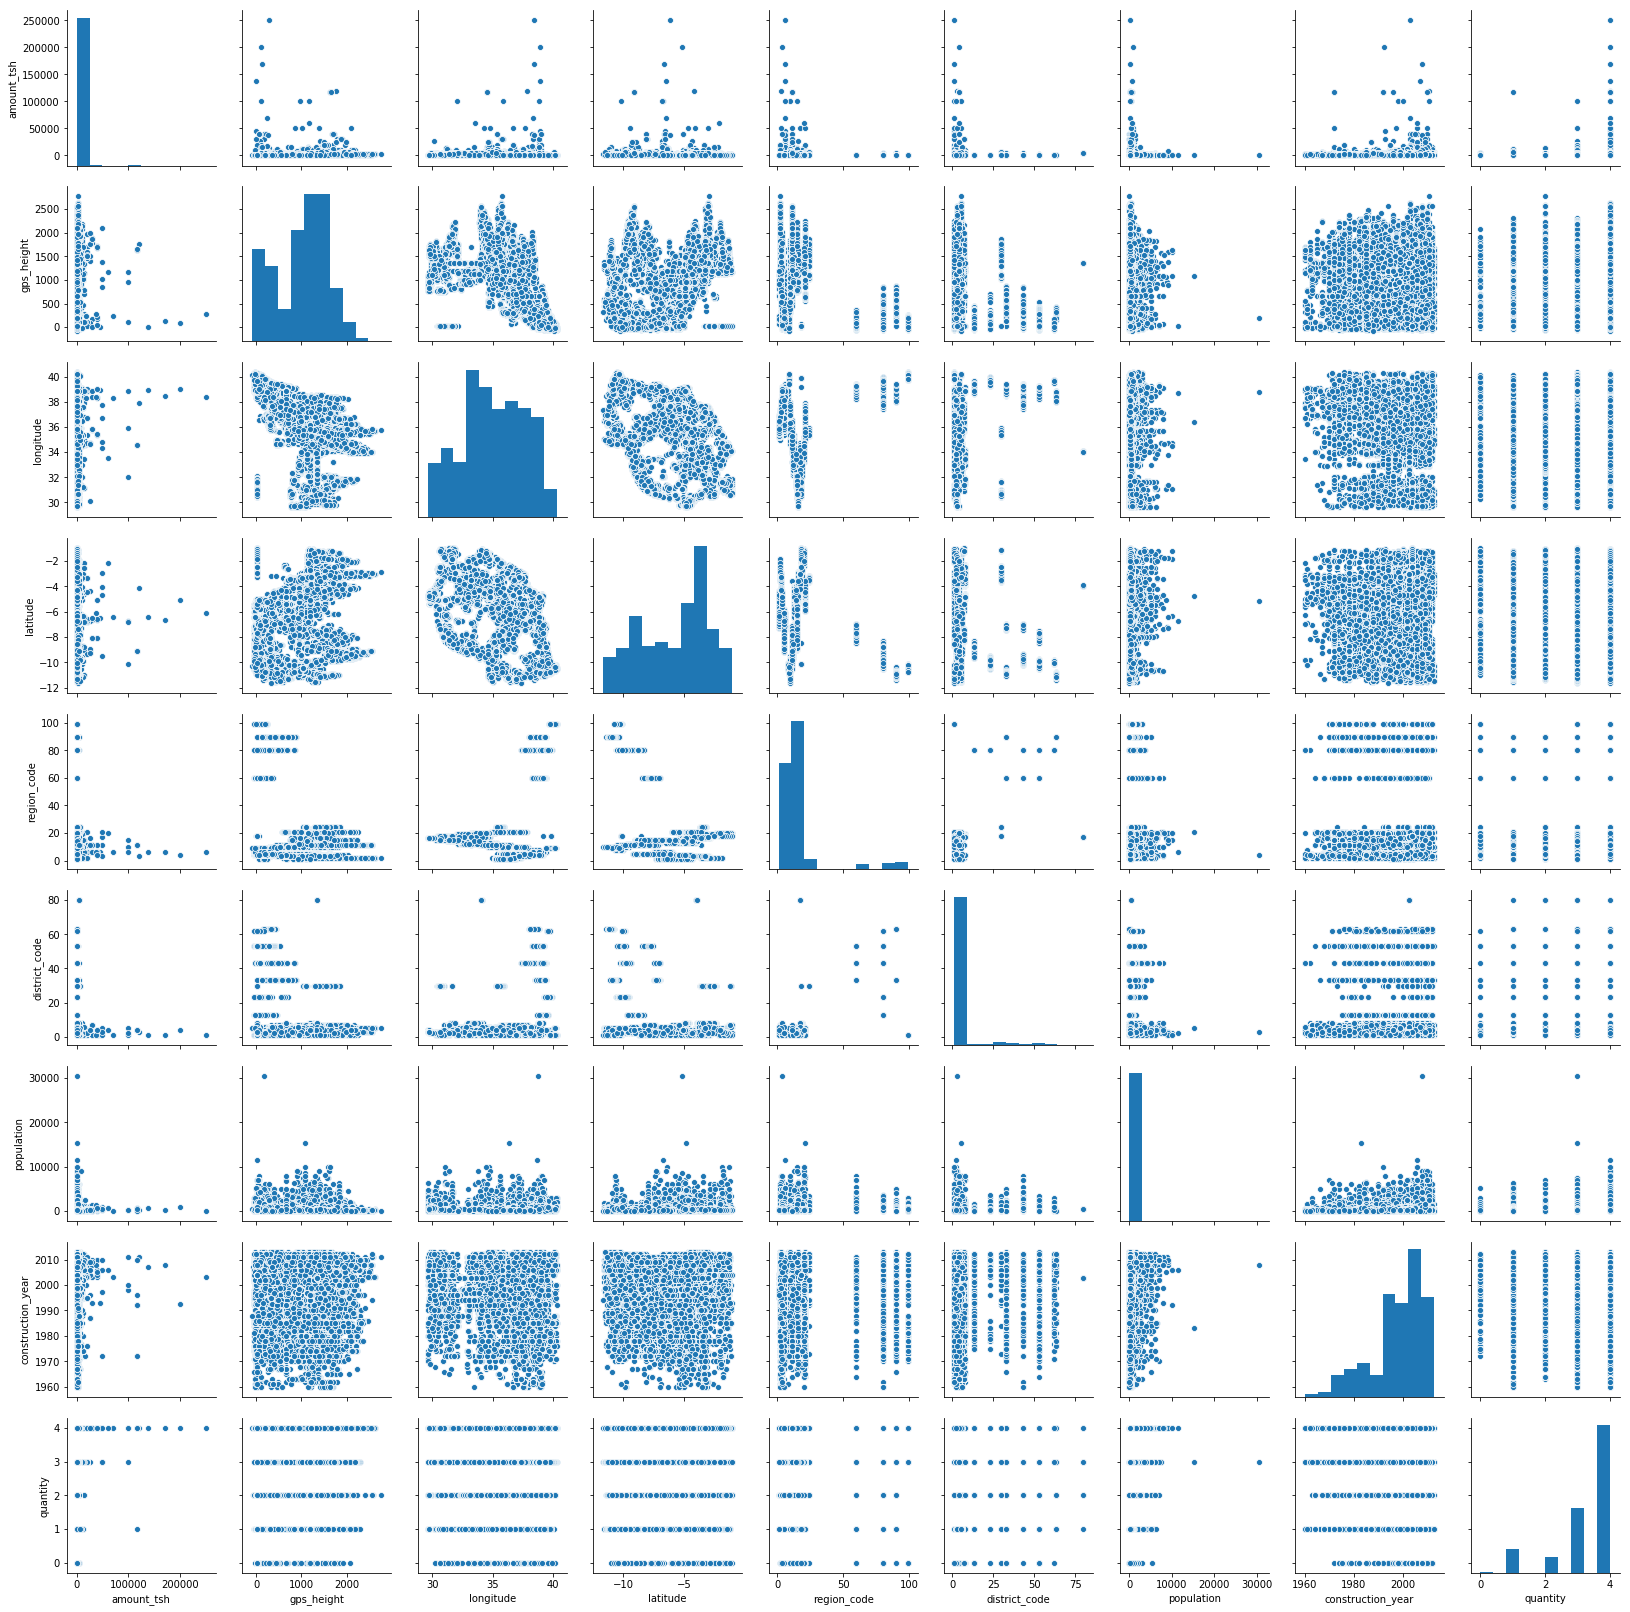

In [18]:
sns.pairplot(df);

In [19]:
df.describe()

,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year,quantity
count,53091.000000,53091.000000,53091.000000,53091.000000,53091.000000,53091.000000,53091.000000,53091.000000,53091.000000
mean,1256.638728,1000.370562,35.067397,-5.718031,15.545121,5.691974,304.956538,1997.765619,3.322296
std,2855.786906,563.442370,2.607021,2.823907,18.122212,9.720901,466.166133,10.417360,0.975189
min,0.200000,-90.000000,29.607122,-11.649440,1.000000,1.000000,1.000000,1960.000000,0.000000
25%,250.000000,501.000000,33.149041,-8.350232,5.000000,2.000000,100.000000,1994.050704,3.000000
50%,808.990632,1119.000000,35.003772,-4.886804,12.000000,3.000000,240.000000,1999.000000,4.000000
75%,1653.842179,1350.981707,37.180822,-3.334495,17.000000,5.000000,420.000000,2005.000000,4.000000
max,250000.000000,2770.000000,40.345193,-0.998464,99.000000,80.000000,30500.000000,2013.000000,4.000000


In [20]:
df.describe(exclude = 'number')

,funder,installer,basin,region,lga,ward,extraction_type,extraction_type_group,management,water_quality,source,source_class,waterpoint_type,status_group
count,53091,53091,53091,53091,53091,53091,53091,53091,53091,53091,53091,53091,53091,53091
unique,1782,1800,9,20,116,1973,18,13,10,7,8,2,7,3
top,government,dwe,lake victoria,iringa,njombe,igosi,gravity,gravity,vwc,soft,spring,groundwater,communal standpipe,functional
freq,9539,16768,9545,5217,2486,307,24126,24126,36398,46969,15629,41264,24659,29289


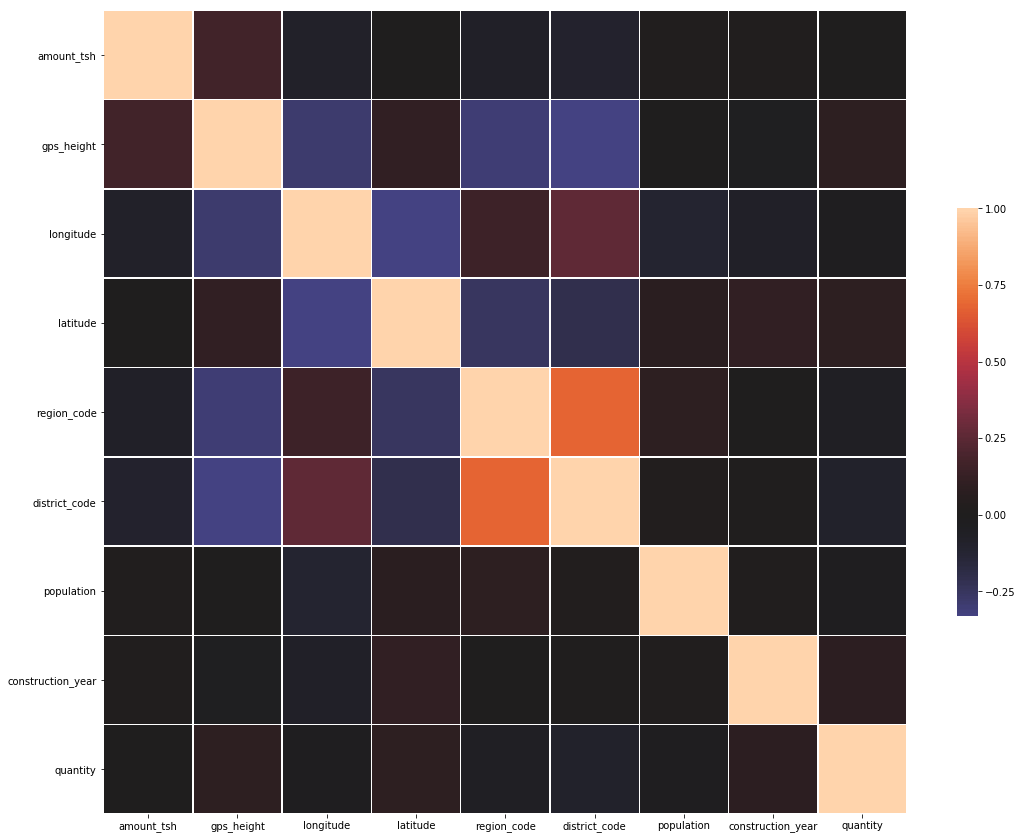

In [21]:
# A quick Correlation Plot

corr = df.corr()
corr

f, ax = plt.subplots(figsize=(18, 15))

sns.heatmap(corr, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

This gives me a good baseline to interpret the data further down. Intuitively I know that foreign investment in [developing countries does not always go as planned](https://www.nytimes.com/2015/01/25/world/africa/mosquito-nets-for-malaria-spawn-new-epidemic-overfishing.html). So a good first glance might be beneficial. However, since there are roughly 1800 unique Financiers and Installers financing and building the pumps, I'll cherry pick some of the more important ones. These entities are responsible for a large number of the water pumps in the nation. 

Below is a chart depicting a sample of 10 Fianciers with their success rates:

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


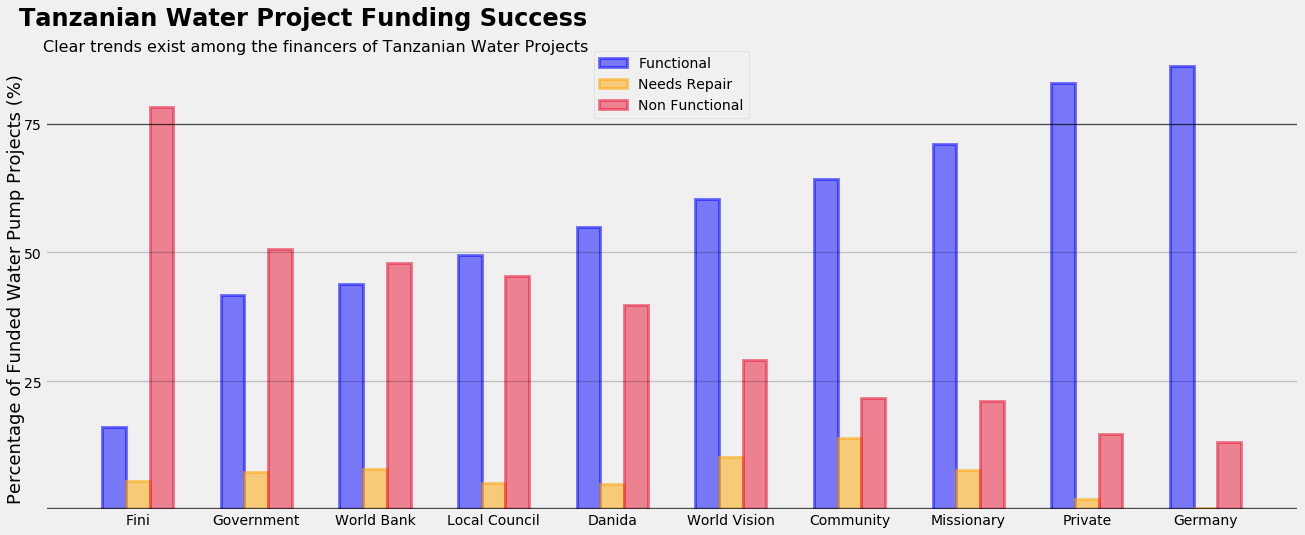

In [22]:

########## Data Wrangling for the Plot ####################

funder_list = ['community','government','danida','world bank','private',
               'local council','world vision','missionary','fini','germany']

funders = df.loc[df['funder'].isin(funder_list)]
funders['funder'] = funders['funder'].str.title()

fund_plot = (round(pd.crosstab(funders['funder'], funders['status_group'], 
                              normalize = 'index')*100,2)
             .sort_values(by = ['non functional'], ascending = False))

################# Plot Creation ###################

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(20 , 8))

# Defining variables for plottling
n_groups = fund_plot['functional'].nunique() 
index = np.arange(n_groups)
width = .2
opacity = .5
linewidth = 3

# My plots, by Functionality
functional     = plt.bar(index, fund_plot['functional'], width, 
                         alpha=opacity, color='blue',
                         edgecolor = 'blue', linewidth = linewidth,
                         label = 'Functional')

needs_repair   = plt.bar(index + width, 
                        fund_plot['functional needs repair'], width, 
                        alpha=opacity, color='orange',
                        edgecolor = 'orange', linewidth = linewidth,
                        label = 'Needs Repair')

non_functional = plt.bar(index + 2*width, fund_plot['non functional'], width, 
                         alpha=opacity, color='#E91436',
                         edgecolor = '#E91436', linewidth = linewidth,
                         label = 'Non Functional')


# Axis lines and dividers
plt.axhline(y = .4, color = 'black', linewidth = 1.3, alpha = .7) 
plt.axhline(y = 75, color = 'black', linewidth = 1.3, alpha = .7)  
plt.axhline(y = 50, color = 'black', linewidth = 1.3, alpha = .2)  
plt.axhline(y = 25, color = 'black', linewidth = 1.3, alpha = .2) 

# Title and text
plt.text(x = -.9 , y = 82, s = 'Percentage of Funded Water Pump Projects (%)',
        fontsize = 18, rotation = 90,)
ax.text(x=-.8,y=94, s = "Tanzanian Water Project Funding Success",
       fontsize = 24, fontweight = 'bold')
ax.text(x= -.6,y=89, s = "Clear trends exist among the financers of Tanzanian Water Projects",
       fontsize = 16)

# Set up ticks and margins
x_ticks = fund_plot.index.values.tolist()

ax.set_yticks([25,50,75])
plt.xticks([.2,1.2,2.2,3.2,4.2,5.2,6.2,7.2,8.2,9.2]  , x_ticks )
ax.grid(False)

plt.legend(loc = 9)

plt.show();


So there are some pretty clear trends. For example, the Germans are very good at making sure their investment is well executed. As a former colony of Germany, Tanzania has received consistent aid from Germany throughout the late 20th and 21st Century. Similarly, pumps funded by private investors (wealthier individuals maintianing their own pump) and local communities fair well. 

On the other hand, the larger investors like the World Bank and Tanzanian government don't fair nearly as well. This may be due to the sheer number of projects invested in by these institutions however. To verify this, I put together a similar chart displaying Installer success rates.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


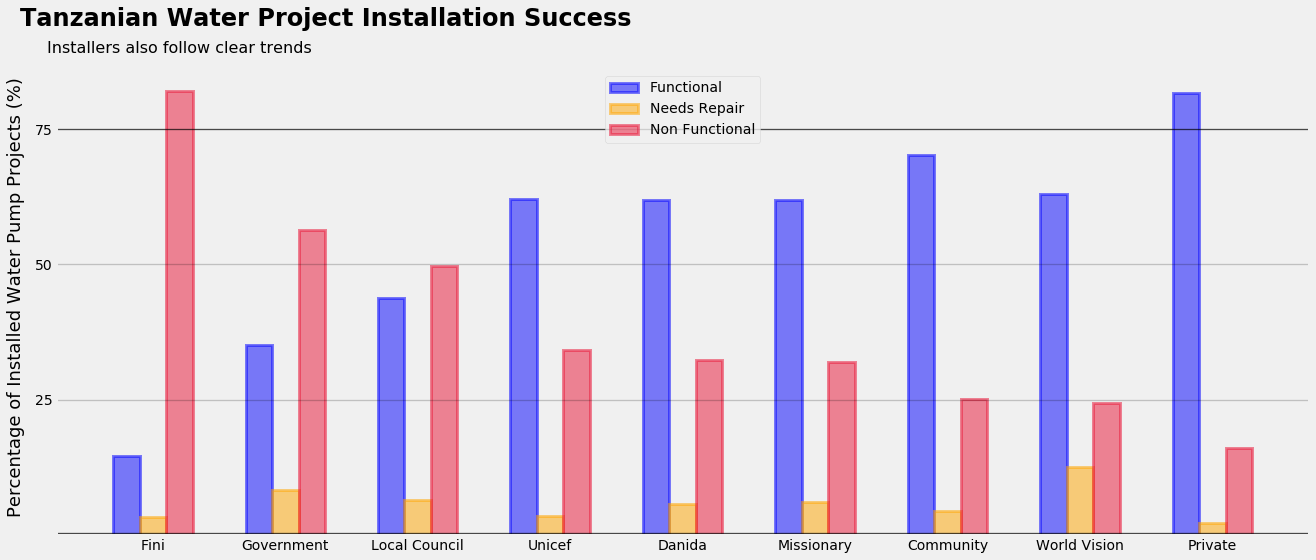

In [23]:

########## Data Wrangling for the Plot ####################
installer_list = ['government','community','danida','local council',
                  'fini','unicef','private','missionary', 'world vision']

installers = df.loc[df['installer'].isin(installer_list)]
installers['installer'] = installers['installer'].str.title()
inst_plot = (round(pd.crosstab(installers['installer'], installers['status_group'], 
                              normalize = 'index')*100,2)
             .sort_values(by = ['non functional'], ascending = False))
                  
                  
################# Plot Creation ###################

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(20 , 8))

# Defining variables for plottling
n_groups = inst_plot['functional'].nunique() 
index = np.arange(n_groups)
width = .2
opacity = .5
linewidth = 3

# My plots, by Functionality
functional     = plt.bar(index, inst_plot['functional'], width, 
                         alpha=opacity, color='blue',
                         edgecolor = 'blue', linewidth = linewidth,
                         label = 'Functional')

needs_repair   = plt.bar(index + width, 
                        inst_plot['functional needs repair'], width, 
                        alpha=opacity, color='orange',
                        edgecolor = 'orange', linewidth = linewidth,
                        label = 'Needs Repair')

non_functional = plt.bar(index + 2*width, inst_plot['non functional'], width, 
                         alpha=opacity, color='#E91436',
                         edgecolor = '#E91436', linewidth = linewidth,
                         label = 'Non Functional')


# Axis lines and dividers
plt.axhline(y = .4, color = 'black', linewidth = 1.3, alpha = .7) 
plt.axhline(y = 75, color = 'black', linewidth = 1.3, alpha = .7)  
plt.axhline(y = 50, color = 'black', linewidth = 1.3, alpha = .2)  
plt.axhline(y = 25, color = 'black', linewidth = 1.3, alpha = .2) 

# Title and text
plt.text(x = -.9 , y = 82, s = 'Percentage of Installed Water Pump Projects (%)',
        fontsize = 18, rotation = 90,)
ax.text(x=-.8,y=94, s = "Tanzanian Water Project Installation Success",
       fontsize = 24, fontweight = 'bold')
ax.text(x= -.6,y=89, s = "Installers also follow clear trends",
       fontsize = 16)

# Set up ticks and margins
x_ticks = inst_plot.index.values.tolist()

ax.set_yticks([25,50,75])
plt.xticks([.2,1.2,2.2,3.2,4.2,5.2,6.2,7.2,8.2]  , x_ticks )
ax.grid(False)

plt.legend(loc = 9)

plt.show();


For the most part, the trends remain the same. Private owners of water pumps are incredibly successful for example. One the other hand, the Tanzanian Government does not have a good record for pump operationality. In fact, one of the big events in Tanzanian Water Investment is the [privatization of the former Capital's water supply](https://en.wikipedia.org/wiki/Water_privatization_in_Dar_es_Salaam), which was thrust upon it by the World Bank. The Tanzanian Government demonstrated that it could not effectively manage the water supply in Dar es Salaam and was only allowed to continue receiving investments from the World Bank if it complied with the privatization request. This eventually ended in scandal when the contract was dissolved two years after it began with top executives being deported. 




> All this is to say that investor and installer are incredibly important features. 

Yet, this information leads us in another direction of inquiry. _Fini_ appears to have a **very** negative track record with non functional water pumps. This helps our model predict if a waterpump is functional, but it can also lead us in another direction. They appear to have such a negative track record because _Fini_ did most of it's installations between 30 to 40 years ago. It is likely that they were not maintained since I can find nothing on the internet pertaining to _Fini_. 

In [24]:
df['construction_year'] = df['construction_year'].astype(int)

fini_df = (pd.DataFrame(df.loc[df['funder'] == 'fini']['construction_year']
                       .value_counts().sort_index('index'))
           .rename(columns = {'construction_year':'# of Pumps Constructed'}))
        
fini_df.loc[fini_df['# of Pumps Constructed'] > 3]


,# of Pumps Constructed
1971,11
1976,9
1977,4
1978,35
1979,12
1980,61
1981,25
1982,12
1983,9
1984,14


Finally, I want to touch upon the population feature. The following maps illustrate population density around pumps with corresponding pump status. 

In [25]:
locations = df.groupby('lga').first()

locations = locations[['latitude', 'longitude']]

subset = df[df['status_group'] == 'non functional']
non_function_count = subset.groupby('lga')[['status_group']].count()

non_function_count = non_function_count.join(locations)



subset_functional = df[df['status_group'] == 'functional']
functional_count = subset_functional.groupby('lga')[['status_group']].count()

functional_count = functional_count.join(locations)


top_50_pop = (df.sort_values('population', ascending = False)
              .head(100)[['latitude','longitude','lga']])




m = folium.Map(location = [df['latitude'].mean(), df['longitude'].mean()],
               zoom_start = 7,
               tiles = 'Stamen Terrain',
)



for index, row in non_function_count.iterrows():
    function_count = (row['status_group'])
    radius         = function_count / 10
    
    folium.CircleMarker(location = (row['latitude'],
                                    row['longitude']),
                        radius = radius, 
                        color = 'crimson',
                        fill = True).add_to(m)
    
    
for index, row in functional_count.iterrows():
    function_count = (row['status_group'])
    radius         = function_count / 20
    
    folium.CircleMarker(location = (row['latitude'],
                                    row['longitude']),
                        radius = radius, 
                        color = 'blue',
                        fill = True).add_to(m)
    
    

for i in np.arange(len(top_50_pop)):
    folium.Marker(location = [top_50_pop.iloc[i]['latitude'],
                              top_50_pop.iloc[i]['longitude']]).add_to(m)
 

m


## Modeling

##### Baseline Prediction

I want to establish the accuracy of the baseline as well as the distribution of classes in the target. 

>- The baseline will be if every prediciton were that the water pump was functional. 

>- The distribution of classes will give me a baseline of how accurate my model's predicitons are.
>- It is a quick way of determining the accuracy against the vaildation dataset, assuming the distribution is similar. 

In [26]:
non_base = ['non functional', 'functional needs repair']
y_pred   = feature_info['status_group'].replace(non_base, 'functional')
y_true = y

print('Baseline Accuracy Score: ' , accuracy_score(y_true, y_pred))

Baseline Accuracy Score:  0.543080808080808


In [27]:
target_distribution = y.value_counts(normalize = True) 
print("Target Distribution:",'\n')
print(target_distribution)

Target Distribution: 

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64


I won't identify all the models I used in the iterative process. Instead I aim to keep the modeling portion of this notebook lean. Below is the Gradient Boost Model that with optimized parameters. Important parameters to note:

>- objective = 'multi:softmax', num_class = 3
> This parameter tunes the model to classifying a target with multiple classes. The number of 
> classes in this case is "**3**".

>- eval_metric = 'merror'
> This parameter tunes the model to make it's decisions via the multiclass error metric. 
> calculated via: _(wrong cases)/(all cases)_.

In [28]:
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
                        max_depth=17, min_child_weight=1, missing=None, n_estimators=100,
                        n_jobs=-1, nthread=None, objective='multi:softmax',num_class=3,
                        random_state=5, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                        seed=42, silent=True, subsample=1, eval_metric='merror')

model.fit(X , y)

y_pred_1 = model.predict(X_val)

score_1 = (cross_val_score(model, X, y, 
                          cv = 10, 
                          scoring = 'accuracy',
                          n_jobs = -1,
                          verbose = 10)).mean()

print('Prediciton Distribution')
print(pd.DataFrame(y_pred_1)[0].value_counts(normalize = True),'\n\n\n')

print('CV-10 Accuracy Score: ' ,score_1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  4.5min remaining: 10.6min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  4.6min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  4.6min remaining:  2.0min


Prediciton Distribution
functional                 0.644310
non functional             0.315155
functional needs repair    0.040535
Name: 0, dtype: float64 



CV-10 Accuracy Score:  0.8072560059068616


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  6.6min finished


The model appears to be fairly accurate. More importantly, the model is relying on some of the features that intuitively make sense. 

As noted below, on the chart ranking feature importance; **quantity** plays a big role in the model, as does **location**, **equipment type**, **population**, **financial sponsor** and **installer**. Another factor that is identified by the model is the **altitude** (gps height). Altitude actually has a huge effect on how [hard a pump has to work to extract water](https://www.absolutewaterpumps.com/how-altitude-affects-water-pump). 

Next, I will check the permutation importance to see if removing noisier or less useful features changes how the model approaches the problem. This process can be iterated on several times to optimize for explainability while incrementally sacrificing peak model accuracy. 

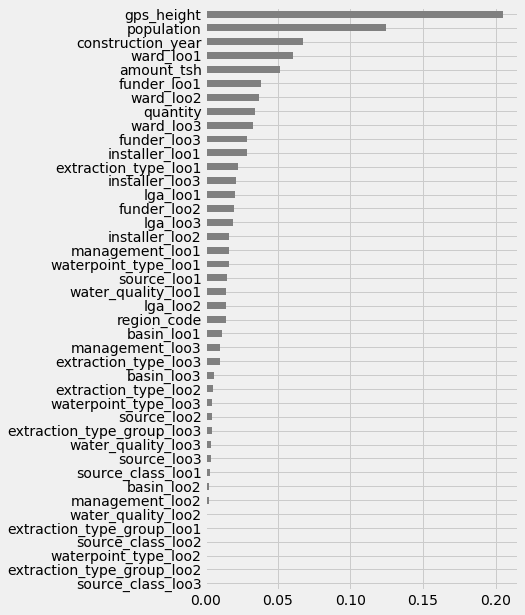

In [29]:
# Creating a Dataframe for later comparison. 
FI_1 = pd.DataFrame(data = model.feature_importances_, 
                    index = X.columns, 
                    columns = ['First Model Feature Importances'])

# Plotting Feature Importances
figsize = (5, 10)
(pd.Series(model.feature_importances_, X.columns)
 .sort_values()
 .plot.barh(color = 'gray', 
            figsize = figsize));

In [30]:
# In its current (May 2019) form, eli5 doesn't work with pandas and XGBoost. It needs to be an array. 
## Likely because it renames the columns to some hardcoded value. 
### https://www.kaggle.com/dansbecker/permutation-importance#392299

X_train_dbg = X_train.values
y_train_dbg = y_train.values
X_test_dbg = X_test.values
y_test_dbg = y_test.values

# The model also needs to fit with the nd.array data type
model.fit(X_train_dbg, y_train_dbg)

permuter = PermutationImportance(model, scoring = 'accuracy',
                                 n_iter = 10, random_state = 42)

# Fit the permuter
permuter.fit(X_test_dbg, y_test_dbg)


feature_names = X_test.columns.tolist()

# Joining my two Dataframes
perm_df = (eli5.explain_weights_df(permuter,
                                   top = None, 
                                   feature_names = feature_names)
           .set_index('feature')
           .join(FI_1))

# This returns an html image that is color shaded to indicate permutation importance. 
eli5.show_weights(permuter, top = None, feature_names = feature_names)

Weight,Feature
0.1044 ± 0.0079,quantity
0.0333 ± 0.0040,waterpoint_type_loo1
0.0244 ± 0.0051,ward_loo2
0.0226 ± 0.0055,ward_loo1
0.0110 ± 0.0041,construction_year
0.0089 ± 0.0037,population
0.0088 ± 0.0026,funder_loo1
0.0087 ± 0.0031,ward_loo3
0.0083 ± 0.0021,extraction_type_loo1
0.0053 ± 0.0021,installer_loo1


## Final Edit when the information

Permutation matrices work by shuffling each feature and testing the change in accuracy score after each iteration. Some features remain high in importance such as Quantity and location. However, gps_height drops significantly in permutation importance, implying that this feature might actually be noise. This is debatable since the confidence interval is so large on the permutation weight. A positive permutation weight is within 2 standard deviations of the mean permuatation weight. It may not be noise, but it may just be marginally useful. 

In [31]:
mask = permuter.feature_importances_ > 0
features = X.columns[mask]

In [32]:
model_2 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
                        max_depth=17, min_child_weight=1, missing=None, n_estimators=100,
                        n_jobs=-1, nthread=None, objective='multi:softmax',num_class=3,
                        random_state=5, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                        seed=42, silent=True, subsample=1, eval_metric='merror')

model_2.fit(X[features], y)

y_pred_2 = model_2.predict(X_val[features])

score_2 = (cross_val_score(model_2, X[features], y, 
                          cv = 10, 
                          scoring = 'accuracy',
                          n_jobs = -1,
                          verbose = 10)).mean()

print('Prediciton Distribution')
print(pd.DataFrame(y_pred_2)[0].value_counts(normalize = True),'\n\n\n')
print('Model Metrwics')
print('CV-10 Accuracy Score: ' , score_2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  3.1min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  3.2min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  3.2min remaining:  1.4min


Prediciton Distribution
functional                 0.645912
non functional             0.313623
functional needs repair    0.040465
Name: 0, dtype: float64 



Model Metrwics
CV-10 Accuracy Score:  0.806767770564606


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.6min finished


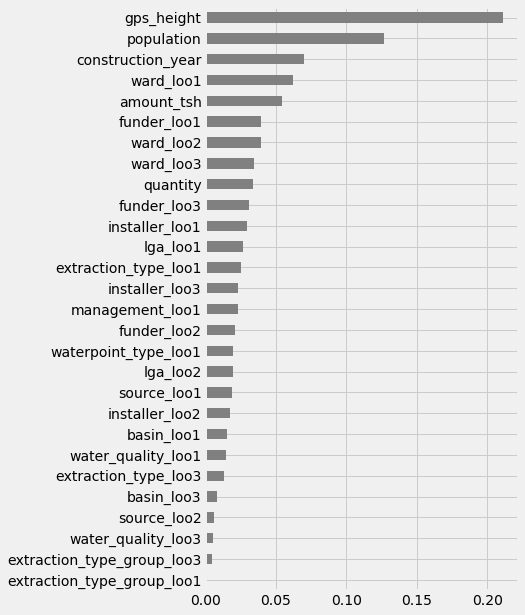

In [33]:
figsize = (5, 10)

FI_2 = pd.DataFrame(data = model_2.feature_importances_, 
                    index = X[features].columns, 
                    columns = ['Second Model Feature Importances'])

(pd.Series(model_2.feature_importances_, X[features].columns)
 .sort_values()
 .plot.barh(color = 'gray', 
            figsize = figsize));

In [34]:
## A quick repeat of this cell to dial into new permuation importances. I
## I will then cherry pick the top candidates for further analysis. 

X_train_per = X_train[features].values
y_train_per = y_train.values
X_test_per  = X_test[features].values
y_test_per  = y_test.values

model_2.fit(X_train_per, y_train)

permuter_2 = PermutationImportance(model_2, scoring = 'accuracy',
                               n_iter = 10, random_state = 42)
permuter_2.fit(X_test_per, y_test_per)
feature_names = X_test[features].columns.tolist()

eli5.show_weights(permuter_2, top = None, feature_names = feature_names)

Weight,Feature
0.1033 ± 0.0060,quantity
0.0327 ± 0.0048,waterpoint_type_loo1
0.0241 ± 0.0041,ward_loo1
0.0218 ± 0.0076,ward_loo2
0.0107 ± 0.0045,extraction_type_loo1
0.0098 ± 0.0024,funder_loo1
0.0090 ± 0.0035,ward_loo3
0.0085 ± 0.0036,construction_year
0.0085 ± 0.0029,population
0.0053 ± 0.0033,installer_loo1


In [35]:
    # Increasing my minimum threshold. I only want more impactful features. 
mask = permuter.feature_importances_ > 0.0015
features = X.columns[mask]

model_3 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
                        max_depth=17, min_child_weight=1, missing=None, n_estimators=100,
                        n_jobs=-1, nthread=None, objective='multi:softmax',num_class=3,
                        random_state=5, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                        seed=42, silent=True, subsample=1, eval_metric='merror')

model_3.fit(X[features], y)

y_pred_3 = model_3.predict(X_val[features])

score_3 = (cross_val_score(model_3, X[features], y, 
                          cv = 10, 
                          scoring = 'accuracy',
                          n_jobs = -1,
                          verbose = 10)).mean()

print('Prediciton Distribution')
print(pd.DataFrame(y_pred_3)[0].value_counts(normalize = True),'\n\n\n')
print('Model Metrics')
print('CV-10 Accuracy Score: ' , score_3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.6min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.6min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.7min remaining:   42.6s


Prediciton Distribution
functional                 0.660468
non functional             0.303942
functional needs repair    0.035590
Name: 0, dtype: float64 



Model Metrics
CV-10 Accuracy Score:  0.8013132759773356


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.5min finished


In [36]:
print("Model Scores:",'\n')
print('Model 1: ', score_1)
print('Model 2: ', score_2)
print('Model 3: ', score_3)

Model Scores: 

Model 1:  0.8072560059068616
Model 2:  0.806767770564606
Model 3:  0.8013132759773356


## Model Performance and Interpretability

As I aggressively removed features, model performance dropped slightly. With that marginal loss in performance comes increased interpretability. Below is a force plot depicting the Shapley Values determined by my model. From here I can look at what the model emphasized and how that paid off. In this case I represent a randomly selected sample where the model correctly predicted that the pump was not functioning. It then provided with the Shapley Values specific to that sample. 

In [39]:
#### Creating the data to feed into the Shap library

model_3.fit(X_train[features], y_train)
y_pred_4 = model_3.predict(X_test[features])
test_pred_df = (pd.DataFrame(y_pred_4, 
                             columns = ['prediction'])
                 .join(y_test.reset_index()))

true_positives = (test_pred_df.loc[test_pred_df['prediction'] == 'non functional']
                  .loc[test_pred_df['status_group'] == 'non functional'])

tp_index = true_positives.sample(n=1)['index'].values.tolist()

data_for_prediction = X_test[features][X_test.index == tp_index] # My Sample. 

# The shap utilizes Java Script to create a visualization. 
shap.initjs()

explainer = shap.TreeExplainer(model_3)
shap_values = explainer.shap_values(data_for_prediction)

#### Matplotlib support for the Shap library is still very new. It doesn't seem to respond to
##### to any parameters. 
shap.force_plot(explainer.expected_value[2], shap_values[2], round(data_for_prediction, 2))


#### In Conclusion:

Predictive modeling can be useful to root out correlation in seemingly impenetrable Dataset. With the right tools and effective data cleaning, actionable insight can be gleaned from the noise. In this case, precise prediction can be used to more efficiently allocate limited resources or calculate the risk in certain builders or investors. 